![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=Vertex+AI+Prediction+Endpoints+for+Online+Forecasting+With+Prophet.ipynb)

# Vertex AI Prediction Endpoints for Online Forecasting With Prophet

Sometimes forecasting needs to be done in the moment to support applications like anomaly detection.  These are near real-time requirements where a given recent time-series can be used to train a forecast model that is used to predict the near-future.  The predictions can be used as expected range of behavior for a process that is monitored and then flagged if it deviates from the expectaiton.  

Most forecasting techniques are done in batch.  For this application an online training and serving applicaiton need to be built.  

The workflow:
- Build Forecasting Code with Prophet
- Build A Custom Prediction Routine that run the forecasting code
- Deploy the Custom Prediction Routine to a Vertex AI Online Endpoint
- Get Forecast on-demand


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/Vertex%20AI%20Prediction%20Endpoints%20for%20Online%20Forecasting%20With%20Prophet.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment.  Also, the APIs for Cloud Speech-To-Text and Cloud Text-To-Speech need to be enabled (if not already enabled).

### Installs (If Needed)
The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [65]:
packages = [
    ('stan', 'pystan'),
    ('prophet', 'prophet'),
    ('bigframes', 'bigframes'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [54]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'online-prophet'
SERIES = 'applied-forecasting'

In [6]:
BQ_REGION = REGION[0:2]

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

In [8]:
from google.cloud import aiplatform
from prophet import Prophet
import bigframes.pandas as bf

In [9]:
aiplatform.init(project = PROJECT_ID, location = REGION)
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION

In [70]:
# already create Artifact Registry Repository:
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}"

In [66]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

In [67]:
DIR = f'temp/{EXPERIMENT}'
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Time Series Data

Use the [BigFrames API](https://cloud.google.com/python/docs/reference/bigframes/latest) to work directly with the prepared time series data from BigQuery:


Link to data as dataframe:

In [17]:
df = bf.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}")

HTML(value='Query job 1efcc378-3890-44b0-84de-ff4c18edb3c3 is RUNNING. <a target="_blank" href="https://consol…

Use Pandas methods to evaluate the dataframe:

In [18]:
df.shape

HTML(value='Query job c6598780-0dd4-41e3-9e27-e7bf3f8045d0 is DONE. 0 Bytes processed. <a target="_blank" href…

(4382, 8)

In [19]:
df.dtypes

start_station_name         string[pyarrow]
starttime             date32[day][pyarrow]
num_trips                            Int64
avg_tripduration                   Float64
pct_subscriber                     Float64
ratio_gender                       Float64
capacity                             Int64
splits                     string[pyarrow]
dtype: object

Get a list of unique station names:

In [20]:
stations = df['start_station_name'].unique().tolist()
stations

HTML(value='Query job 50455405-b7d0-4189-8c57-60f4fd2292fe is DONE. 163.8 kB processed. <a target="_blank" hre…

['Central Park S & 6 Ave',
 'Central Park West & W 72 St',
 'Grand Army Plaza & Central Park S',
 'W 82 St & Central Park West',
 'Central Park West & W 100 St',
 'Central Park West & W 85 St',
 'Central Park North & Adam Clayton Powell Blvd',
 'Central Park West & W 76 St',
 'Central Park West & W 68 St',
 'Central Park West & W 102 St',
 'Central Park W & W 96 St',
 'W 106 St & Central Park West']

Review a single time series:

In [23]:
df[df['start_station_name'] == stations[0]].sort_values(by = ['starttime'])

HTML(value='Query job f8246c7c-623d-45dc-82f8-35e56efaeeee is DONE. 128.8 kB processed. <a target="_blank" hre…

HTML(value='Query job b0104ea4-5841-4eb8-b0d7-a3389aef0d7d is DONE. 403.5 kB processed. <a target="_blank" hre…

HTML(value='Query job be6691d1-676d-4ec6-b30b-1772661e6d23 is DONE. 0 Bytes processed. <a target="_blank" href…

,start_station_name,starttime,num_trips,avg_tripduration,pct_subscriber,ratio_gender,capacity,splits
1730,Central Park S & 6 Ave,2013-07-01,69,1532.144928,0.652174,1.464286,73,TRAIN
3685,Central Park S & 6 Ave,2013-07-02,180,1817.505556,0.327778,0.363636,73,TRAIN
2626,Central Park S & 6 Ave,2013-07-03,115,1615.504348,0.4,0.455696,73,TRAIN
3614,Central Park S & 6 Ave,2013-07-04,175,2225.331429,0.297143,0.241135,73,TRAIN
3881,Central Park S & 6 Ave,2013-07-05,195,2213.061538,0.215385,0.203704,73,TRAIN
4158,Central Park S & 6 Ave,2013-07-06,222,1812.40991,0.18018,0.168421,73,TRAIN
207,Central Park S & 6 Ave,2013-07-07,266,1942.007519,0.214286,0.1875,73,TRAIN
3113,Central Park S & 6 Ave,2013-07-08,143,2368.783217,0.328671,0.361905,73,TRAIN
3193,Central Park S & 6 Ave,2013-07-09,148,1942.959459,0.554054,0.741176,73,TRAIN
3095,Central Park S & 6 Ave,2013-07-10,142,1868.626761,0.514085,0.690476,73,TRAIN


---
## Prepare Data For Prophet

Prophet expects a dataframe for a single time series with columns `ds` for timestamp and `y` for the demand variable of the forecast. This data has multiple series, one for each station identified in the column `start_station_name`. Below is the code to create a dataframe for a given `start_station_name`.

In [24]:
stations[0]

'Central Park S & 6 Ave'

In [28]:
ts = df[(df['start_station_name'] == stations[0]) & (df['splits'] != 'TEST')][['starttime','num_trips']].rename(columns = {'starttime': 'ds', 'num_trips': 'y'}).sort_values(by = ['ds'])

In [35]:
ts.head()

HTML(value='Query job b47e259f-6d54-4853-bf79-bc0add2641cc is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 9bc22ff7-1032-445a-9355-3d5c5c977fc0 is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 71d59651-c221-47fd-a1ca-9e3bb2850aaf is DONE. 0 Bytes processed. <a target="_blank" href…

,ds,y
1730,2013-07-01,69
3685,2013-07-02,180
2626,2013-07-03,115
3614,2013-07-04,175
3881,2013-07-05,195


Move a copy of the prepared data in `ts` to a local Pandas dataframe with `to_pandas()` method.

In [39]:
local_ts = ts.to_pandas()

HTML(value='Query job c58fc5d4-4aee-4baa-af6d-625d0daceeac is DONE. 265.0 kB processed. <a target="_blank" hre…

In [41]:
type(ts), type(local_ts)

(bigframes.dataframe.DataFrame, pandas.core.frame.DataFrame)

---
## Create Forecast Model For Single Time Series - Locally (In Notebook)

Fit with seasonality and holidays added:

In [42]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(local_ts)

[DEBUG][2023-09-05 20:12:44,202][cmdstanpy] input tempfile: /var/tmp/tmp9tjc8xz0/6ouiofls.json
[DEBUG][2023-09-05 20:12:44,293][cmdstanpy] input tempfile: /var/tmp/tmp9tjc8xz0/z26qa79o.json
[DEBUG][2023-09-05 20:12:44,322][cmdstanpy] idx 0
[DEBUG][2023-09-05 20:12:44,322][cmdstanpy] running CmdStan, num_threads: None
[DEBUG][2023-09-05 20:12:44,324][cmdstanpy] CmdStan args: ['/opt/conda/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1265', 'data', 'file=/var/tmp/tmp9tjc8xz0/6ouiofls.json', 'init=/var/tmp/tmp9tjc8xz0/z26qa79o.json', 'output', 'file=/var/tmp/tmp9tjc8xz0/prophet_modelq869zbn5/prophet_model-20230905201244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:44 - cmdstanpy - INFO - Chain [1] start processing
[INFO][2023-09-05 20:12:44,325][cmdstanpy] Chain [1] start processing
20:12:44 - cmdstanpy - INFO - Chain [1] done processing
[INFO][2023-09-05 20:12:44,419][cmdstanpy] Chain [1] done processing


Make dataframe for forecast by adding periods to the known date range of the training data. If you only want the forecast horizone then use the option `include_history = False`.

In [45]:
future = p.make_future_dataframe(periods = 2*14, include_history = False)
future.head()

,ds
0,2016-09-17
1,2016-09-18
2,2016-09-19
3,2016-09-20
4,2016-09-21


Generate the predictions for the forecast horizon. Since we kept the default that include the training history dates, we also get fit information for each of these dates.

In [46]:
forecast = p.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-17,201.815061,288.913859,440.377540,201.815061,201.815061,0.0,0.0,0.0,0.0,...,51.071301,51.071301,51.071301,79.598499,79.598499,79.598499,0.0,0.0,0.0,362.321883
1,2016-09-18,201.983953,287.952881,439.779814,201.983953,201.983953,0.0,0.0,0.0,0.0,...,58.079214,58.079214,58.079214,75.813931,75.813931,75.813931,0.0,0.0,0.0,365.714120
2,2016-09-19,202.152845,212.359098,365.578894,202.152845,202.152845,0.0,0.0,0.0,0.0,...,-13.180703,-13.180703,-13.180703,71.851156,71.851156,71.851156,0.0,0.0,0.0,290.660320
3,2016-09-20,202.321737,197.030875,347.991780,202.321737,202.321737,0.0,0.0,0.0,0.0,...,-27.552479,-27.552479,-27.552479,67.766558,67.766558,67.766558,0.0,0.0,0.0,272.372838
4,2016-09-21,202.490629,195.481405,345.884583,202.490629,202.490629,0.0,0.0,0.0,0.0,...,-26.074759,-26.074759,-26.074759,63.618574,63.618574,63.618574,0.0,0.0,0.0,269.871466


Use the built in plotting capabilites of Prophet to review the time series with forecast:

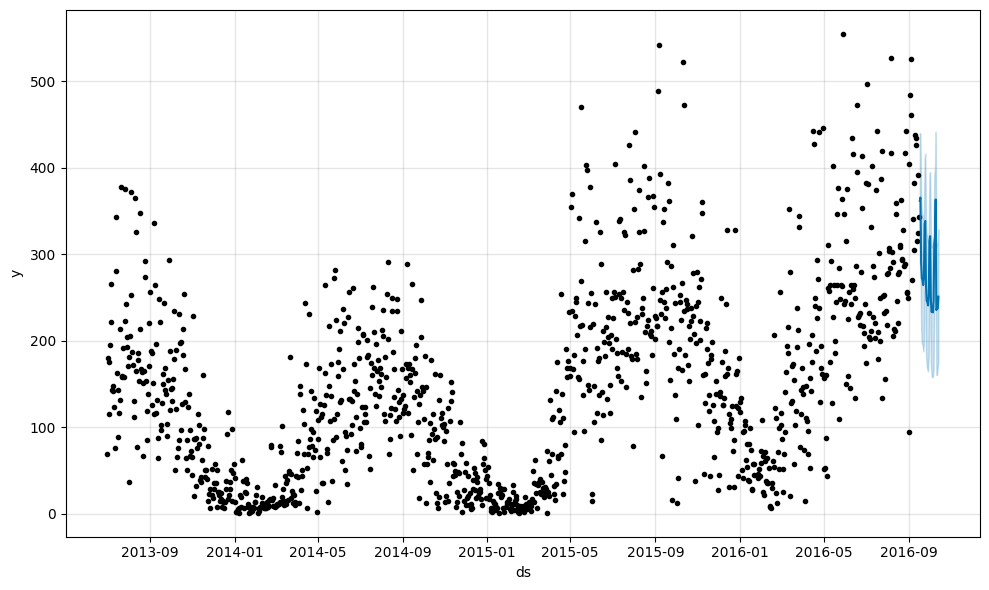

In [50]:
p.plot(forecast);

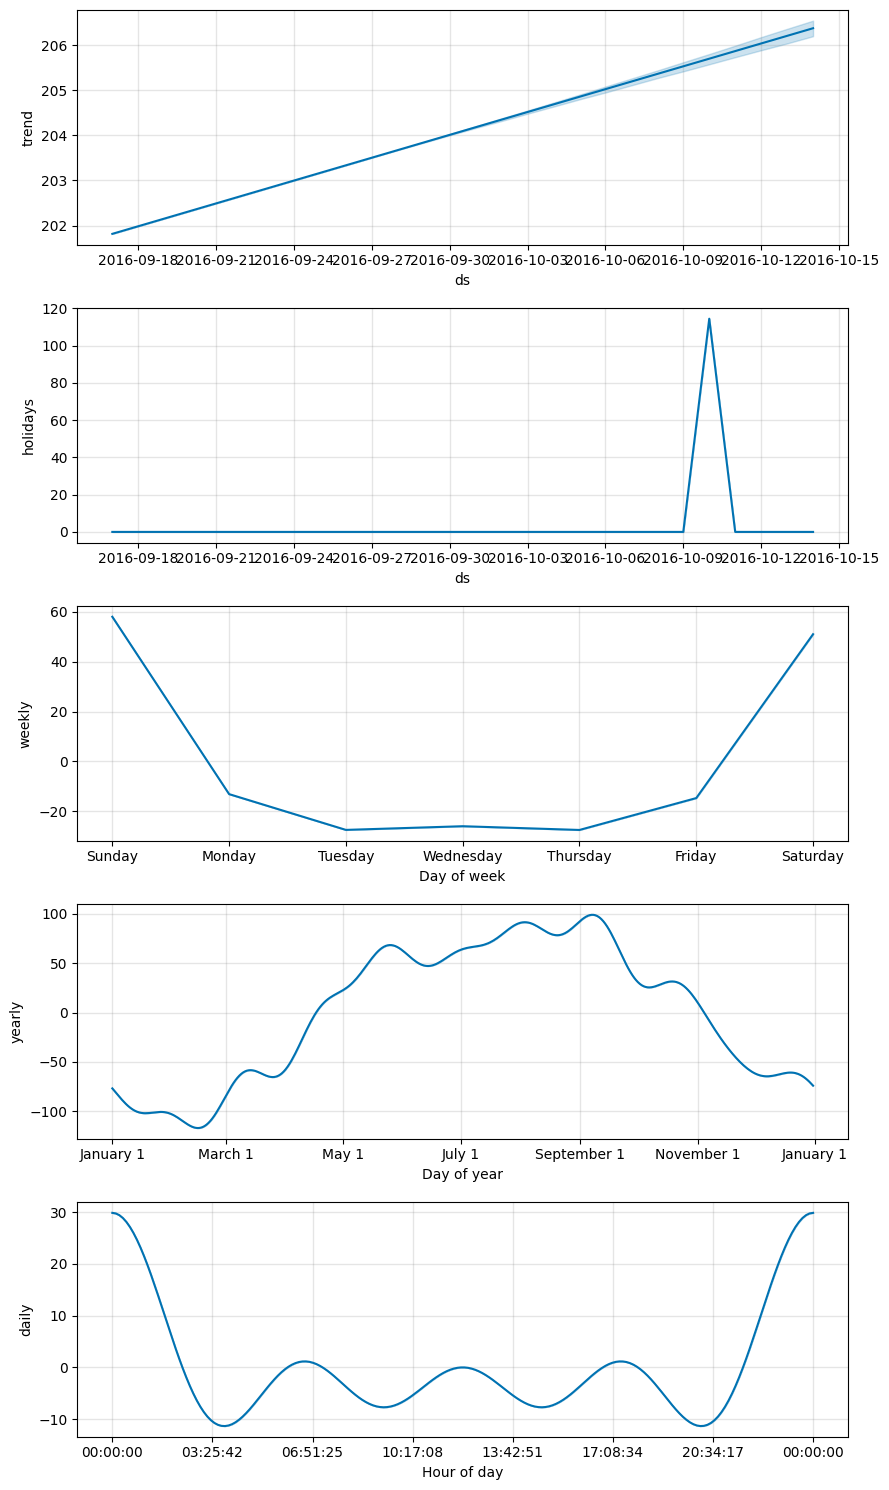

In [51]:
p.plot_components(forecast);

Format `forecast` data as json for transport:

In [77]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[0:2].to_dict()

{'ds': {0: Timestamp('2016-09-17 00:00:00'),
  1: Timestamp('2016-09-18 00:00:00')},
 'yhat': {0: 362.32188328977406, 1: 365.71411998933894},
 'yhat_lower': {0: 288.9138594529242, 1: 287.95288123043383},
 'yhat_upper': {0: 440.3775396793928, 1: 439.7798138073954}}

---
## Build Custom Prediction Routine

[Custom Prediction Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) - A custom container built by the Vertex AI SDK that assist with pre/post processing code without the need to setup an HTTP server.

Make a local folder for source code:

In [68]:
!mkdir -p {DIR}/SRC

Create a `requirements.txt` file with the required Python packages:

In [69]:
%%writefile {DIR}/SRC/requirements.txt
fastapi
uvicorn==0.17.6
pandas
google-cloud-aiplatform[prediction]>=1.16.0
pystan
prophet

Writing temp/online-prophet/SRC/requirements.txt


Create a `predictor.py` file with the prediction routine:

In [ ]:
%%writefile {DIR}/SRC/predictor.py

# packages
from google.cloud.aiplatform.prediction.predictor import Predictor
from prophet import Prophet

def forecast():
    
    p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(ts)
    
    future = p.make_future_dataframe(periods = 10, include_history = False)
    forecast = p.predict(future)
    
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_dict()
    
    return forecast
    
class CprPredictor(Predictor):
    def __init__(self):
        return
    
    def load(self, artifacts_uri: str) -> None:
        # no model to load here, this example trans a model and returns predictions/forecast
        
    def predict(self, instances):
        
        instances = instances['instances']
        results = [f"{forecast(instance)}" for instance in instances]
        
        return ("forecast": results)

---
## Run Custom Prediction Routine - Locally (In Notebook)

This will require a user-managed workbench due to requirement for Docker.

In [ ]:
Load Local Model:

In [ ]:
from google.cloud.aiplatform.prediction import LocalModel
# load the local predictor class:
from temp.cpr_training.SRC.predictor import CprPredictor

local_model = LocalModel.build_cpr_model(
    src_dir = f"{DIR}/SRC",
    output_image_uri = f"{REPOSITORY}/{SERIES}_{EXPERIMENT}",
    predictor = CprPredictor,
    requirements_path = os.path.join(f"{DIR}/SRC", "requirements.txt"),
)

In [ ]:
Host Local Model:

In [ ]:
with local_model.deploy_to_local_endpoint() as local_endpoint:
    predict_response = local_endpoint.predict(
        request = '{"instances": [100, 1000, 2000, 3000]}',
        headers={"Content-Type": "application/json"}
    )

    health_check_response = local_endpoint.run_health_check()

---
## Push Model To Vertex AI